In [1]:
%conda install seaborn

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   py38h578d9bd_2         145 KB  conda-forge
    conda-4.12.0               |   py38h578d9bd_0         1.0 MB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    freetype-2.10.4            |       h0708190_1         890 KB  conda-forge
    jbig-2.1                   |    h7f98852_2003          43 KB  conda-forge
    jpeg-9e                    |       h166bdaf_1         268 KB  conda-forge
    kiwisolver-1.4.2           |   py38h43d8883_1          75 KB  conda-forge
    lcms2-2.12                 |       hddcbb42_0         443 KB  conda-forge
    lerc-2.2.1                

In [2]:
%conda install ipywidgets

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ipywidgets


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    argon2-cffi-21.3.0         |     pyhd8ed1ab_0          15 KB  conda-forge
    argon2-cffi-bindings-21.2.0|   py38h0a891b7_2          34 KB  conda-forge
    bleach-5.0.0               |     pyhd8ed1ab_0         123 KB  conda-forge
    defusedxml-0.7.1           |     pyhd8ed1ab_0          23 KB  conda-forge
    entrypoints-0.4            |     pyhd8ed1ab_0           9 KB  conda-forge
    flit-core-3.7.1            |     pyhd8ed1ab_0          44 KB  conda-forge
    importlib-metadata-4.11.3  |   py38h578d9bd_1          33 KB  conda-forge
    importlib_resources-5.7.0  |     pyhd8ed1ab_0          22 KB  conda-forge
    ipykernel-5.5.5            |   py38hd0cf306_0         167 KB  conda-forge
    ipywidgets-7.7.0       

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import string
import pickle
import os

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import seaborn as sn
import pandas as pd

from datetime import datetime
import multiprocessing

import copy
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, models

from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# fix randomness for reproducibility
# torch.manual_seed(0)
np.random.seed(0)
SKL_SEED=0

In [6]:
# hyperparameters
BATCH_SIZE=1024
EPOCHS=100
worker_num=10#multiprocessing.cpu_count()
print(worker_num)

# run name for tensorboard (to distinguish different runs)
# to access tensorboard, in cmd run: tensorboard --logdir=runs
# then open in browser: localhost:6006
timestamp = datetime.now().strftime("%d_%m_%Y-%H_%M_%S")
run_name = 'pres_resnet_bn_weight_decay_'+timestamp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

10
cuda:0


In [7]:
def makeUpright(x):
    return x.permute(0,2,1)

"""
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1793,), (0.3353,)),
     transforms.Lambda(makeUpright)])
"""

transform = transforms.Compose(
    [#transforms.Normalize((mean,), (std,)),
     #transforms.RandomPerspective(distortion_scale=0.9),
     #transforms.RandomAffine(5, translate=(2/28, 2/28), interpolation=transforms.InterpolationMode.BILINEAR),#, scale=(0.9, 1.1), shear=(20,20)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,)),
     transforms.Lambda(makeUpright),
    ])

class GetEmnistLoader:
    
    def __init__(
        self, characters=string.ascii_uppercase, train_val_size=-1, num_folds=5,
        transform=None,
        num_workers=worker_num
    ):
        
        self.num_folds = num_folds
        
        self.num_workers=num_workers
        
        test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),transforms.Lambda(makeUpright)])
        if transform == None: transform = test_transform
        """
        self.data_sets = {}
        
        for split in ["train_val","train","val","test"]
            self.data_sets[split] = datasets.EMNIST(
                "./data_sets", split='byclass', train=True, download=True, transform=test_transform)
            mask = np.array([b for b in sum(train_val_data.targets==i for i in classes)], dtype=bool)
            self.data_sets[split] = train_val_data.data[mask]
            self.data_sets[split] = train_val_data.targets[mask]
            for i, c in enumerate(classes): train_val_data.targets[train_val_data.targets == c] = i
        """
        # get data from the emnist data set
        train_val_data = datasets.EMNIST("./data_sets", split='byclass', train=True, download=True, transform=None)
        self.train_data = datasets.EMNIST("./data_sets", split='byclass', train=True, download=True, transform=transform)
        self.val_data = datasets.EMNIST("./data_sets", split='byclass', train=True, download=True, transform=test_transform)
        test_data = datasets.EMNIST("./data_sets", split='byclass', train=False, download=True, transform=test_transform)

        classes = [i for i,s in enumerate(test_data.classes) if s in characters]

        mask = np.array([b for b in sum(test_data.targets==i for i in classes)], dtype=bool)
        test_data.data = test_data.data[mask]
        test_data.targets = test_data.targets[mask]
        for i, c in enumerate(classes): test_data.targets[test_data.targets == c] = i
    
        mask = np.array([b for b in sum(train_val_data.targets==i for i in classes)], dtype=bool)
        train_val_data.data = train_val_data.data[mask]
        train_val_data.targets = train_val_data.targets[mask]
        for i, c in enumerate(classes): train_val_data.targets[train_val_data.targets == c] = i
    
        assert train_val_size <= len(train_val_data), "val_train_size larger than val_train_set!"
        if train_val_size == -1:
            train_val_size = len(train_val_data)
        else:
            indices = np.arange(len(train_val_data))
            sel_indices, _ = train_test_split(indices, train_size=train_val_size, stratify=train_val_data.targets, random_state=SKL_SEED)
            train_val_data.data = train_val_data.data[sel_indices]
            train_val_data.targets = train_val_data.targets[sel_indices]
        
        if self.num_folds>=2:
            X = train_val_data.data
            y = train_val_data.targets

            skf = StratifiedKFold(n_splits=num_folds)
            self.tidx = []
            self.vidx = []
            for ti, vi in skf.split(X, y):
                self.tidx.append(ti)
                self.vidx.append(vi)

        self.classes = [s for s in test_data.classes if s in characters]
        self.num_classes = len(classes)

        self.train_data.classes = self.classes
        self.val_data.classes = self.classes
        test_data.classes = self.classes
        train_val_data.classes = self.classes
        self.train_val_data = train_val_data

        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False)


    def cross_validation(self, fold=0):

        if self.num_folds>=2:
            self.train_data.data = self.train_val_data.data[self.tidx[fold]]
            self.train_data.targets = self.train_val_data.targets[self.tidx[fold]]

            self.val_data.data = self.train_val_data.data[self.vidx[fold]]
            self.val_data.targets = self.train_val_data.targets[self.vidx[fold]]

            train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=BATCH_SIZE, num_workers=self.num_workers, shuffle=True)
            val_loader = torch.utils.data.DataLoader(self.val_data, batch_size=BATCH_SIZE, num_workers=self.num_workers, shuffle=False)
        else:
            train_loader = torch.utils.data.DataLoader(self.train_val_data, batch_size=BATCH_SIZE, num_workers=self.num_workers, shuffle=True)
            val_loader = self.test_loader

        return train_loader, val_loader

    def independant_data(self):
        return self.test_loader, self.classes, self.num_classes

In [3]:
# model
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 'same')
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 'same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 'same')
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 'same')
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(7*7*128, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, num_classes)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


class FcNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 'same')
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 'same')
        self.bn2 = nn.BatchNorm2d(64)
        
        self.iconv1 = nn.Conv2d(1, 64, kernel_size=1, stride=1, bias=False)
        self.ibn1 = nn.BatchNorm2d(64) 
        
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)        
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 'same')
        self.bn4 = nn.BatchNorm2d(128)
        
        self.iconv2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False)
        self.ibn2 = nn.BatchNorm2d(128)        
        
        self.conv5 = nn.Conv2d(128, 256, 3, 2, 1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, 1, 'same')
        self.bn6 = nn.BatchNorm2d(256)
        
        self.iconv3 = nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False)
        self.ibn3 = nn.BatchNorm2d(256)
        
        self.conv7 = nn.Conv2d(256, 512, 3, 2, 1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, 1, 'same')
        self.bn8 = nn.BatchNorm2d(512)
        
        self.iconv4 = nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False)
        self.ibn4 = nn.BatchNorm2d(512)
        
        self.fc = nn.Linear(512, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        x = out + self.ibn1(self.iconv1(x))
        out = F.relu(self.bn3(self.conv3(x)))
        out = self.bn4(self.conv4(out))
        x = out + self.ibn2(self.iconv2(x))
        out = F.relu(self.bn5(self.conv5(x)))
        out = self.bn6(self.conv6(out))
        x = out + self.ibn3(self.iconv3(x))
        out = F.relu(self.bn7(self.conv7(x)))
        out = self.bn8(self.conv8(out))
        x = out + self.ibn4(self.iconv4(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [4]:
def train_model(model, criterion, optimizer, scheduler=False, num_epochs=30):
    best_model_state_dict = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    learning_stats = {'train': [], 'val': []}
        
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_ground_truth = []
            epoch_predictions = []
            running_loss = 0.0
            
            if phase=='train':
                disable=False
            else: disable=True
            
            for inputs, labels in tqdm(dataloaders[phase], disable=disable):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                      
                epoch_ground_truth = epoch_ground_truth + labels.data.tolist()
                epoch_predictions = epoch_predictions + preds.tolist()
                running_loss += loss.item() * inputs.size(0)
                
            if scheduler:
                if phase == 'train':
                    scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = accuracy_score(epoch_ground_truth, epoch_predictions)
            epoch_weighted_acc = balanced_accuracy_score(epoch_ground_truth, epoch_predictions)
            epoch_weighted_rec = recall_score(epoch_ground_truth, epoch_predictions, average='weighted')
            epoch_weighted_prec = precision_score(epoch_ground_truth, epoch_predictions, average='weighted')
            epoch_weighted_f1 = f1_score(epoch_ground_truth, epoch_predictions, average='weighted')
            
            learning_stats[phase].append(
                {'loss': epoch_loss, 
                 'accuracy': epoch_acc, 
                 'weighted_accuracy': epoch_weighted_acc,
                 'weighted_precision': epoch_weighted_prec,
                 'weighted_recall': epoch_weighted_rec,
                 'weighted_f1': epoch_weighted_f1})
            
            print('[{}, {}] Loss: {:.4f} Acc: {:.4f} Weighted Acc: {:.4f} Weighted Pre: {:.4f} Weighted Rec: {:.4f} Weighted F1: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc, epoch_weighted_acc, epoch_weighted_prec, epoch_weighted_rec, epoch_weighted_f1))
            
            if phase == 'train':
                writer = train_writer
            else:
                writer = val_writer
                
            writer.add_scalar('Loss', epoch_loss, epoch)
            writer.add_scalar('Accuracy', epoch_acc, epoch)
            
            if (phase == 'val') and (epoch_acc > best_accuracy):
                best_accuracy = epoch_acc
                best_model_state_dict = copy.deepcopy(model.state_dict())
                  
    return best_model_state_dict, learning_stats


def eval_model(model, dataloader):
    
    epoch_ground_truth = []
    epoch_predictions = []
    
    ic_imgs=[]
    ic_truth=[]
    ic_preds=[]
    
    model.eval()
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        
        idxs_mask = (preds != labels).view(-1)
        
        ic_imgs.append(inputs[idxs_mask].cpu().numpy())
        ic_truth = np.append(ic_truth, labels[idxs_mask].cpu().numpy())
        ic_preds = np.append(ic_preds, preds[idxs_mask].cpu().numpy())
        
        epoch_ground_truth = epoch_ground_truth + labels.data.tolist()
        epoch_predictions = epoch_predictions + preds.tolist()
    
    ic_imgs = np.squeeze(np.concatenate(ic_imgs, axis=0))
    
    return accuracy_score(epoch_ground_truth, epoch_predictions), zip(ic_imgs, ic_truth, ic_preds)


# helper functions

def matplotlib_imshow(img, one_channel=False):
    '''
    helper function to show an image
    '''
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def labeled_random_batch(data_loader):
    # get some random training images
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    # plot the images in the batch, along with true labels
    col_num=8
    row_num=(BATCH_SIZE-1)//col_num+1
    fig = plt.figure(figsize=(col_num*3, row_num*3))
    for idx in np.arange(BATCH_SIZE):
        ax = fig.add_subplot(row_num, col_num, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title(classes[labels[idx]])

    # write to tensorboard
    run_writer.add_figure('labeled_batch', fig)

def add_embedding(data_set, n):
    # select random images and their target indices
    images, labels = select_n_random(data_set.data, data_set.targets)

    # get the class labels for each image
    class_labels = [classes[lab] for lab in labels]

    size=torch.tensor(images.shape[1:]).prod()

    # log embeddings
    features = images.view(-1, size)
    run_writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
    run_writer.close()

def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    col_num=8
    row_num=(BATCH_SIZE-1)//col_num+1
    fig = plt.figure(figsize=(col_num*3, row_num*3))
    for idx in np.arange(BATCH_SIZE):
        ax = fig.add_subplot(row_num, col_num, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    run_writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    run_writer.close()

def create_pr_curves(net, data_loader):
    # 1. gets the probability predictions in a test_size x num_classes Tensor
    # 2. gets the preds in a test_size Tensor
    # takes ~10 seconds to run
    class_probs = []
    class_label = []
    with torch.no_grad():
        for data, target in testloader:
            images, labels = data.to(device), target.to(device)
            output = net(images)
            class_probs_batch = [F.softmax(el, dim=0) for el in output]

            class_probs.append(class_probs_batch)
            class_label.append(labels)

    test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
    test_label = torch.cat(class_label)

    # plot all the pr curves
    for i in range(len(classes)):
        add_pr_curve_tensorboard(i, test_probs, test_label)

def create_confusion_matrix(net, data_loader):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for data, target in data_loader:
        inputs, labels = data.to(device), target.to(device)
        output = net(inputs)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth


    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, normalize = 'true')
    df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)
    fig = plt.figure(figsize=(28, 14))
    sn.heatmap(df_cm, annot=True, fmt='.2f').set(title="ground truth normalized", xlabel="predicted", ylabel="ground truth")
    return fig

In [27]:
# get data loaders
num_folds=5
emnist_loader = GetEmnistLoader(characters=string.ascii_uppercase, train_val_size = -1, num_folds=num_folds, transform = transform)

testloader, classes, num_classes = emnist_loader.independant_data()

run_writer = SummaryWriter('runs/'+run_name)

# create projector thing
add_embedding(testloader.dataset, 100)

for fold in range(1):
    
    print('-----------[Fold: {}]-----------'.format(fold))

    trainloader, valloader = emnist_loader.cross_validation(fold)

    # initialize network, loss function and optimizer
    net = ResNet(num_classes).to(device)
    
    sample_counts = emnist_loader.train_data.targets.bincount()
    weights = torch.tensor(sample_counts.sum()/(num_classes*sample_counts), dtype=torch.float32, device='cuda:0')
    #print(weights)
    
    criterion = nn.CrossEntropyLoss()#weight=weights)
    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0.001)
    exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer, step_size=10, gamma=0.5)
    
    # initialize SummmaryWriters, default `log_dir` is "runs" - added child-dirs for train, test and others
    train_writer = SummaryWriter('runs/'+run_name+'/train/fold_'+str(fold))
    val_writer = SummaryWriter('runs/'+run_name+'/val/fold_'+str(fold))

    # show one batch to check if dataset is correctly initialized
    #labeled_random_batch(trainloader)
    
    data_sets = {'train': emnist_loader.train_data, 'val': emnist_loader.val_data}
    dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}
    
    dataloaders = {}
    dataloaders['train'] = trainloader
    dataloaders['val'] = valloader

    bestModel, learningStats = train_model(net, criterion, optimizer, num_epochs=EPOCHS)#, scheduler=exp_lr_scheduler)

    os.makedirs('training_results', exist_ok=True)
    pickle.dump(learningStats, open(os.path.join('training_results', 'learning_stats_'+run_name+'.p'), 'wb'))
    torch.save(bestModel, os.path.join('training_results', 'best_model_'+run_name+'.pt'))
    
    print('Finished Training')
    
    print("{:.3f}%".format(eval_model(net, testloader)[0]*100))
    
    create_pr_curves(net, testloader)
    run_writer.add_figure("Confusion matrix", create_confusion_matrix(net, testloader))

-----------[Fold: 0]-----------



[0, train] Loss: 0.9301 Acc: 0.7587 Weighted Acc: 0.6624 Weighted Pre: 0.7594 Weighted Rec: 0.7587 Weighted F1: 0.7509
[0, val] Loss: 0.2888 Acc: 0.9340 Weighted Acc: 0.8974 Weighted Pre: 0.9342 Weighted Rec: 0.9340 Weighted F1: 0.9331



[1, train] Loss: 0.1794 Acc: 0.9579 Weighted Acc: 0.9394 Weighted Pre: 0.9577 Weighted Rec: 0.9579 Weighted F1: 0.9577
[1, val] Loss: 0.1521 Acc: 0.9628 Weighted Acc: 0.9456 Weighted Pre: 0.9630 Weighted Rec: 0.9628 Weighted F1: 0.9627



[2, train] Loss: 0.1155 Acc: 0.9728 Weighted Acc: 0.9623 Weighted Pre: 0.9728 Weighted Rec: 0.9728 Weighted F1: 0.9728
[2, val] Loss: 0.1202 Acc: 0.9699 Weighted Acc: 0.9592 Weighted Pre: 0.9700 Weighted Rec: 0.9699 Weighted F1: 0.9698



[3, train] Loss: 0.0915 Acc: 0.9781 Weighted Acc: 0.9702 Weighted Pre: 0.9780 Weighted Rec: 0.9781 Weighted F1: 0.9780
[3, val] Loss: 0.1208 Acc: 0.9711 Weighted Acc: 0.9633 Weighted Pre: 0.9716 Weighted Rec: 0.9711 Weighted F1: 0.9711



[4, train] Loss: 0.0797 Acc: 0.9809 Weighted Acc: 0.9743 Weighted Pre: 0.9809 Weighted Rec: 0.9809 Weighted F1: 0.9809
[4, val] Loss: 0.0957 Acc: 0.9773 Weighted Acc: 0.9708 Weighted Pre: 0.9773 Weighted Rec: 0.9773 Weighted F1: 0.9773



[5, train] Loss: 0.0705 Acc: 0.9829 Weighted Acc: 0.9771 Weighted Pre: 0.9829 Weighted Rec: 0.9829 Weighted F1: 0.9829
[5, val] Loss: 0.0907 Acc: 0.9780 Weighted Acc: 0.9701 Weighted Pre: 0.9781 Weighted Rec: 0.9780 Weighted F1: 0.9779



[6, train] Loss: 0.0634 Acc: 0.9850 Weighted Acc: 0.9799 Weighted Pre: 0.9850 Weighted Rec: 0.9850 Weighted F1: 0.9850
[6, val] Loss: 0.1011 Acc: 0.9757 Weighted Acc: 0.9711 Weighted Pre: 0.9761 Weighted Rec: 0.9757 Weighted F1: 0.9758



[7, train] Loss: 0.0584 Acc: 0.9863 Weighted Acc: 0.9820 Weighted Pre: 0.9863 Weighted Rec: 0.9863 Weighted F1: 0.9863
[7, val] Loss: 0.0903 Acc: 0.9770 Weighted Acc: 0.9724 Weighted Pre: 0.9775 Weighted Rec: 0.9770 Weighted F1: 0.9771



[8, train] Loss: 0.0533 Acc: 0.9872 Weighted Acc: 0.9831 Weighted Pre: 0.9872 Weighted Rec: 0.9872 Weighted F1: 0.9872
[8, val] Loss: 0.0835 Acc: 0.9776 Weighted Acc: 0.9686 Weighted Pre: 0.9777 Weighted Rec: 0.9776 Weighted F1: 0.9774



[9, train] Loss: 0.0498 Acc: 0.9884 Weighted Acc: 0.9846 Weighted Pre: 0.9884 Weighted Rec: 0.9884 Weighted F1: 0.9884
[9, val] Loss: 0.0827 Acc: 0.9790 Weighted Acc: 0.9757 Weighted Pre: 0.9794 Weighted Rec: 0.9790 Weighted F1: 0.9791



[10, train] Loss: 0.0455 Acc: 0.9897 Weighted Acc: 0.9865 Weighted Pre: 0.9897 Weighted Rec: 0.9897 Weighted F1: 0.9897
[10, val] Loss: 0.0871 Acc: 0.9777 Weighted Acc: 0.9707 Weighted Pre: 0.9780 Weighted Rec: 0.9777 Weighted F1: 0.9777



[11, train] Loss: 0.0426 Acc: 0.9904 Weighted Acc: 0.9877 Weighted Pre: 0.9904 Weighted Rec: 0.9904 Weighted F1: 0.9904
[11, val] Loss: 0.0781 Acc: 0.9798 Weighted Acc: 0.9743 Weighted Pre: 0.9800 Weighted Rec: 0.9798 Weighted F1: 0.9799



[12, train] Loss: 0.0395 Acc: 0.9912 Weighted Acc: 0.9886 Weighted Pre: 0.9912 Weighted Rec: 0.9912 Weighted F1: 0.9912
[12, val] Loss: 0.0809 Acc: 0.9796 Weighted Acc: 0.9739 Weighted Pre: 0.9797 Weighted Rec: 0.9796 Weighted F1: 0.9796



[13, train] Loss: 0.0365 Acc: 0.9922 Weighted Acc: 0.9900 Weighted Pre: 0.9922 Weighted Rec: 0.9922 Weighted F1: 0.9922
[13, val] Loss: 0.0756 Acc: 0.9806 Weighted Acc: 0.9753 Weighted Pre: 0.9807 Weighted Rec: 0.9806 Weighted F1: 0.9806



[14, train] Loss: 0.0338 Acc: 0.9927 Weighted Acc: 0.9907 Weighted Pre: 0.9926 Weighted Rec: 0.9927 Weighted F1: 0.9926
[14, val] Loss: 0.0751 Acc: 0.9794 Weighted Acc: 0.9728 Weighted Pre: 0.9795 Weighted Rec: 0.9794 Weighted F1: 0.9794



[15, train] Loss: 0.0314 Acc: 0.9935 Weighted Acc: 0.9918 Weighted Pre: 0.9935 Weighted Rec: 0.9935 Weighted F1: 0.9935
[15, val] Loss: 0.0744 Acc: 0.9809 Weighted Acc: 0.9759 Weighted Pre: 0.9810 Weighted Rec: 0.9809 Weighted F1: 0.9809



[16, train] Loss: 0.0290 Acc: 0.9943 Weighted Acc: 0.9928 Weighted Pre: 0.9943 Weighted Rec: 0.9943 Weighted F1: 0.9943
[16, val] Loss: 0.0751 Acc: 0.9807 Weighted Acc: 0.9753 Weighted Pre: 0.9807 Weighted Rec: 0.9807 Weighted F1: 0.9806



[17, train] Loss: 0.0269 Acc: 0.9949 Weighted Acc: 0.9937 Weighted Pre: 0.9949 Weighted Rec: 0.9949 Weighted F1: 0.9949
[17, val] Loss: 0.0778 Acc: 0.9805 Weighted Acc: 0.9765 Weighted Pre: 0.9806 Weighted Rec: 0.9805 Weighted F1: 0.9805



[18, train] Loss: 0.0244 Acc: 0.9957 Weighted Acc: 0.9947 Weighted Pre: 0.9957 Weighted Rec: 0.9957 Weighted F1: 0.9957
[18, val] Loss: 0.0752 Acc: 0.9802 Weighted Acc: 0.9717 Weighted Pre: 0.9802 Weighted Rec: 0.9802 Weighted F1: 0.9801



[19, train] Loss: 0.0230 Acc: 0.9957 Weighted Acc: 0.9948 Weighted Pre: 0.9957 Weighted Rec: 0.9957 Weighted F1: 0.9957
[19, val] Loss: 0.0748 Acc: 0.9801 Weighted Acc: 0.9730 Weighted Pre: 0.9801 Weighted Rec: 0.9801 Weighted F1: 0.9800



[20, train] Loss: 0.0213 Acc: 0.9962 Weighted Acc: 0.9954 Weighted Pre: 0.9962 Weighted Rec: 0.9962 Weighted F1: 0.9962
[20, val] Loss: 0.0776 Acc: 0.9805 Weighted Acc: 0.9749 Weighted Pre: 0.9805 Weighted Rec: 0.9805 Weighted F1: 0.9804



[21, train] Loss: 0.0199 Acc: 0.9967 Weighted Acc: 0.9959 Weighted Pre: 0.9967 Weighted Rec: 0.9967 Weighted F1: 0.9967
[21, val] Loss: 0.0762 Acc: 0.9799 Weighted Acc: 0.9738 Weighted Pre: 0.9799 Weighted Rec: 0.9799 Weighted F1: 0.9799



[22, train] Loss: 0.0176 Acc: 0.9972 Weighted Acc: 0.9967 Weighted Pre: 0.9972 Weighted Rec: 0.9972 Weighted F1: 0.9972
[22, val] Loss: 0.0727 Acc: 0.9807 Weighted Acc: 0.9740 Weighted Pre: 0.9807 Weighted Rec: 0.9807 Weighted F1: 0.9807



[23, train] Loss: 0.0164 Acc: 0.9975 Weighted Acc: 0.9970 Weighted Pre: 0.9975 Weighted Rec: 0.9975 Weighted F1: 0.9975
[23, val] Loss: 0.0743 Acc: 0.9801 Weighted Acc: 0.9759 Weighted Pre: 0.9802 Weighted Rec: 0.9801 Weighted F1: 0.9801



[24, train] Loss: 0.0152 Acc: 0.9978 Weighted Acc: 0.9974 Weighted Pre: 0.9978 Weighted Rec: 0.9978 Weighted F1: 0.9978
[24, val] Loss: 0.0713 Acc: 0.9821 Weighted Acc: 0.9771 Weighted Pre: 0.9821 Weighted Rec: 0.9821 Weighted F1: 0.9820



[25, train] Loss: 0.0139 Acc: 0.9981 Weighted Acc: 0.9976 Weighted Pre: 0.9981 Weighted Rec: 0.9981 Weighted F1: 0.9981
[25, val] Loss: 0.0706 Acc: 0.9816 Weighted Acc: 0.9765 Weighted Pre: 0.9816 Weighted Rec: 0.9816 Weighted F1: 0.9815



[26, train] Loss: 0.0126 Acc: 0.9985 Weighted Acc: 0.9982 Weighted Pre: 0.9985 Weighted Rec: 0.9985 Weighted F1: 0.9985
[26, val] Loss: 0.0720 Acc: 0.9815 Weighted Acc: 0.9755 Weighted Pre: 0.9815 Weighted Rec: 0.9815 Weighted F1: 0.9815



[27, train] Loss: 0.0116 Acc: 0.9986 Weighted Acc: 0.9984 Weighted Pre: 0.9986 Weighted Rec: 0.9986 Weighted F1: 0.9986
[27, val] Loss: 0.0753 Acc: 0.9810 Weighted Acc: 0.9734 Weighted Pre: 0.9810 Weighted Rec: 0.9810 Weighted F1: 0.9809



[28, train] Loss: 0.0107 Acc: 0.9990 Weighted Acc: 0.9988 Weighted Pre: 0.9990 Weighted Rec: 0.9990 Weighted F1: 0.9990
[28, val] Loss: 0.0707 Acc: 0.9824 Weighted Acc: 0.9768 Weighted Pre: 0.9824 Weighted Rec: 0.9824 Weighted F1: 0.9823



[29, train] Loss: 0.0102 Acc: 0.9990 Weighted Acc: 0.9988 Weighted Pre: 0.9990 Weighted Rec: 0.9990 Weighted F1: 0.9990
[29, val] Loss: 0.0774 Acc: 0.9805 Weighted Acc: 0.9756 Weighted Pre: 0.9805 Weighted Rec: 0.9805 Weighted F1: 0.9805



[30, train] Loss: 0.0098 Acc: 0.9991 Weighted Acc: 0.9990 Weighted Pre: 0.9991 Weighted Rec: 0.9991 Weighted F1: 0.9991
[30, val] Loss: 0.0736 Acc: 0.9807 Weighted Acc: 0.9740 Weighted Pre: 0.9807 Weighted Rec: 0.9807 Weighted F1: 0.9806



[31, train] Loss: 0.0089 Acc: 0.9994 Weighted Acc: 0.9993 Weighted Pre: 0.9994 Weighted Rec: 0.9994 Weighted F1: 0.9994
[31, val] Loss: 0.0725 Acc: 0.9815 Weighted Acc: 0.9750 Weighted Pre: 0.9815 Weighted Rec: 0.9815 Weighted F1: 0.9814



[32, train] Loss: 0.0082 Acc: 0.9995 Weighted Acc: 0.9994 Weighted Pre: 0.9995 Weighted Rec: 0.9995 Weighted F1: 0.9995
[32, val] Loss: 0.0727 Acc: 0.9813 Weighted Acc: 0.9743 Weighted Pre: 0.9813 Weighted Rec: 0.9813 Weighted F1: 0.9813



[33, train] Loss: 0.0081 Acc: 0.9994 Weighted Acc: 0.9993 Weighted Pre: 0.9994 Weighted Rec: 0.9994 Weighted F1: 0.9994
[33, val] Loss: 0.0732 Acc: 0.9816 Weighted Acc: 0.9766 Weighted Pre: 0.9817 Weighted Rec: 0.9816 Weighted F1: 0.9816



[34, train] Loss: 0.0078 Acc: 0.9994 Weighted Acc: 0.9993 Weighted Pre: 0.9994 Weighted Rec: 0.9994 Weighted F1: 0.9994
[34, val] Loss: 0.0703 Acc: 0.9822 Weighted Acc: 0.9765 Weighted Pre: 0.9821 Weighted Rec: 0.9822 Weighted F1: 0.9821



[35, train] Loss: 0.0074 Acc: 0.9996 Weighted Acc: 0.9995 Weighted Pre: 0.9996 Weighted Rec: 0.9996 Weighted F1: 0.9996
[35, val] Loss: 0.0709 Acc: 0.9817 Weighted Acc: 0.9768 Weighted Pre: 0.9817 Weighted Rec: 0.9817 Weighted F1: 0.9817



[36, train] Loss: 0.0067 Acc: 0.9997 Weighted Acc: 0.9996 Weighted Pre: 0.9997 Weighted Rec: 0.9997 Weighted F1: 0.9997
[36, val] Loss: 0.0709 Acc: 0.9821 Weighted Acc: 0.9784 Weighted Pre: 0.9822 Weighted Rec: 0.9821 Weighted F1: 0.9821



[37, train] Loss: 0.0063 Acc: 0.9998 Weighted Acc: 0.9997 Weighted Pre: 0.9998 Weighted Rec: 0.9998 Weighted F1: 0.9998
[37, val] Loss: 0.0718 Acc: 0.9820 Weighted Acc: 0.9762 Weighted Pre: 0.9820 Weighted Rec: 0.9820 Weighted F1: 0.9819



[38, train] Loss: 0.0058 Acc: 0.9998 Weighted Acc: 0.9997 Weighted Pre: 0.9998 Weighted Rec: 0.9998 Weighted F1: 0.9998
[38, val] Loss: 0.0705 Acc: 0.9821 Weighted Acc: 0.9774 Weighted Pre: 0.9821 Weighted Rec: 0.9821 Weighted F1: 0.9821



[39, train] Loss: 0.0068 Acc: 0.9995 Weighted Acc: 0.9994 Weighted Pre: 0.9995 Weighted Rec: 0.9995 Weighted F1: 0.9995
[39, val] Loss: 0.0733 Acc: 0.9817 Weighted Acc: 0.9748 Weighted Pre: 0.9817 Weighted Rec: 0.9817 Weighted F1: 0.9816



[40, train] Loss: 0.0059 Acc: 0.9998 Weighted Acc: 0.9997 Weighted Pre: 0.9998 Weighted Rec: 0.9998 Weighted F1: 0.9998
[40, val] Loss: 0.0718 Acc: 0.9816 Weighted Acc: 0.9777 Weighted Pre: 0.9816 Weighted Rec: 0.9816 Weighted F1: 0.9816



[41, train] Loss: 0.0056 Acc: 0.9998 Weighted Acc: 0.9998 Weighted Pre: 0.9998 Weighted Rec: 0.9998 Weighted F1: 0.9998
[41, val] Loss: 0.0716 Acc: 0.9820 Weighted Acc: 0.9757 Weighted Pre: 0.9820 Weighted Rec: 0.9820 Weighted F1: 0.9819



[42, train] Loss: 0.0052 Acc: 0.9999 Weighted Acc: 0.9998 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[42, val] Loss: 0.0717 Acc: 0.9818 Weighted Acc: 0.9780 Weighted Pre: 0.9819 Weighted Rec: 0.9818 Weighted F1: 0.9818



[43, train] Loss: 0.0050 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[43, val] Loss: 0.0698 Acc: 0.9828 Weighted Acc: 0.9782 Weighted Pre: 0.9828 Weighted Rec: 0.9828 Weighted F1: 0.9828



[44, train] Loss: 0.0049 Acc: 0.9999 Weighted Acc: 0.9998 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[44, val] Loss: 0.0698 Acc: 0.9823 Weighted Acc: 0.9770 Weighted Pre: 0.9823 Weighted Rec: 0.9823 Weighted F1: 0.9823



[45, train] Loss: 0.0046 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[45, val] Loss: 0.0689 Acc: 0.9824 Weighted Acc: 0.9770 Weighted Pre: 0.9824 Weighted Rec: 0.9824 Weighted F1: 0.9824



[46, train] Loss: 0.0045 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[46, val] Loss: 0.0703 Acc: 0.9825 Weighted Acc: 0.9769 Weighted Pre: 0.9824 Weighted Rec: 0.9825 Weighted F1: 0.9824



[47, train] Loss: 0.0046 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[47, val] Loss: 0.0703 Acc: 0.9823 Weighted Acc: 0.9776 Weighted Pre: 0.9823 Weighted Rec: 0.9823 Weighted F1: 0.9822



[48, train] Loss: 0.0046 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[48, val] Loss: 0.0704 Acc: 0.9824 Weighted Acc: 0.9775 Weighted Pre: 0.9824 Weighted Rec: 0.9824 Weighted F1: 0.9823



[49, train] Loss: 0.0045 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[49, val] Loss: 0.0695 Acc: 0.9826 Weighted Acc: 0.9775 Weighted Pre: 0.9826 Weighted Rec: 0.9826 Weighted F1: 0.9826



[50, train] Loss: 0.0044 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[50, val] Loss: 0.0687 Acc: 0.9829 Weighted Acc: 0.9777 Weighted Pre: 0.9829 Weighted Rec: 0.9829 Weighted F1: 0.9829



[51, train] Loss: 0.0042 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[51, val] Loss: 0.0692 Acc: 0.9831 Weighted Acc: 0.9785 Weighted Pre: 0.9831 Weighted Rec: 0.9831 Weighted F1: 0.9831



[52, train] Loss: 0.0041 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[52, val] Loss: 0.0702 Acc: 0.9823 Weighted Acc: 0.9764 Weighted Pre: 0.9823 Weighted Rec: 0.9823 Weighted F1: 0.9822



[53, train] Loss: 0.0041 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[53, val] Loss: 0.0689 Acc: 0.9830 Weighted Acc: 0.9782 Weighted Pre: 0.9829 Weighted Rec: 0.9830 Weighted F1: 0.9829



[54, train] Loss: 0.0042 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[54, val] Loss: 0.0691 Acc: 0.9827 Weighted Acc: 0.9781 Weighted Pre: 0.9827 Weighted Rec: 0.9827 Weighted F1: 0.9827



[55, train] Loss: 0.0040 Acc: 1.0000 Weighted Acc: 0.9999 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[55, val] Loss: 0.0684 Acc: 0.9831 Weighted Acc: 0.9780 Weighted Pre: 0.9831 Weighted Rec: 0.9831 Weighted F1: 0.9831



[56, train] Loss: 0.0040 Acc: 1.0000 Weighted Acc: 0.9999 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[56, val] Loss: 0.0712 Acc: 0.9823 Weighted Acc: 0.9769 Weighted Pre: 0.9822 Weighted Rec: 0.9823 Weighted F1: 0.9822



[57, train] Loss: 0.0040 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[57, val] Loss: 0.0695 Acc: 0.9829 Weighted Acc: 0.9770 Weighted Pre: 0.9829 Weighted Rec: 0.9829 Weighted F1: 0.9829



[58, train] Loss: 0.0040 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[58, val] Loss: 0.0697 Acc: 0.9827 Weighted Acc: 0.9777 Weighted Pre: 0.9827 Weighted Rec: 0.9827 Weighted F1: 0.9827



[59, train] Loss: 0.0040 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[59, val] Loss: 0.0695 Acc: 0.9824 Weighted Acc: 0.9773 Weighted Pre: 0.9824 Weighted Rec: 0.9824 Weighted F1: 0.9824



[60, train] Loss: 0.0051 Acc: 0.9997 Weighted Acc: 0.9997 Weighted Pre: 0.9997 Weighted Rec: 0.9997 Weighted F1: 0.9997
[60, val] Loss: 0.0723 Acc: 0.9819 Weighted Acc: 0.9753 Weighted Pre: 0.9819 Weighted Rec: 0.9819 Weighted F1: 0.9818



[61, train] Loss: 0.0092 Acc: 0.9987 Weighted Acc: 0.9986 Weighted Pre: 0.9987 Weighted Rec: 0.9987 Weighted F1: 0.9987
[61, val] Loss: 0.0748 Acc: 0.9817 Weighted Acc: 0.9760 Weighted Pre: 0.9818 Weighted Rec: 0.9817 Weighted F1: 0.9817



[62, train] Loss: 0.0073 Acc: 0.9992 Weighted Acc: 0.9991 Weighted Pre: 0.9992 Weighted Rec: 0.9992 Weighted F1: 0.9992
[62, val] Loss: 0.0928 Acc: 0.9761 Weighted Acc: 0.9660 Weighted Pre: 0.9764 Weighted Rec: 0.9761 Weighted F1: 0.9761



[63, train] Loss: 0.0089 Acc: 0.9990 Weighted Acc: 0.9989 Weighted Pre: 0.9990 Weighted Rec: 0.9990 Weighted F1: 0.9990
[63, val] Loss: 0.0716 Acc: 0.9821 Weighted Acc: 0.9764 Weighted Pre: 0.9821 Weighted Rec: 0.9821 Weighted F1: 0.9821



[64, train] Loss: 0.0049 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[64, val] Loss: 0.0684 Acc: 0.9829 Weighted Acc: 0.9777 Weighted Pre: 0.9828 Weighted Rec: 0.9829 Weighted F1: 0.9828



[65, train] Loss: 0.0038 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[65, val] Loss: 0.0678 Acc: 0.9833 Weighted Acc: 0.9779 Weighted Pre: 0.9832 Weighted Rec: 0.9833 Weighted F1: 0.9832



[66, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[66, val] Loss: 0.0689 Acc: 0.9826 Weighted Acc: 0.9764 Weighted Pre: 0.9826 Weighted Rec: 0.9826 Weighted F1: 0.9826



[67, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[67, val] Loss: 0.0677 Acc: 0.9830 Weighted Acc: 0.9777 Weighted Pre: 0.9829 Weighted Rec: 0.9830 Weighted F1: 0.9829



[68, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[68, val] Loss: 0.0683 Acc: 0.9829 Weighted Acc: 0.9774 Weighted Pre: 0.9828 Weighted Rec: 0.9829 Weighted F1: 0.9828



[69, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[69, val] Loss: 0.0673 Acc: 0.9835 Weighted Acc: 0.9785 Weighted Pre: 0.9835 Weighted Rec: 0.9835 Weighted F1: 0.9835



[70, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[70, val] Loss: 0.0679 Acc: 0.9835 Weighted Acc: 0.9780 Weighted Pre: 0.9835 Weighted Rec: 0.9835 Weighted F1: 0.9835



[71, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[71, val] Loss: 0.0677 Acc: 0.9833 Weighted Acc: 0.9781 Weighted Pre: 0.9832 Weighted Rec: 0.9833 Weighted F1: 0.9832



[72, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[72, val] Loss: 0.0685 Acc: 0.9832 Weighted Acc: 0.9769 Weighted Pre: 0.9831 Weighted Rec: 0.9832 Weighted F1: 0.9831



[73, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[73, val] Loss: 0.0686 Acc: 0.9830 Weighted Acc: 0.9773 Weighted Pre: 0.9830 Weighted Rec: 0.9830 Weighted F1: 0.9830



[74, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[74, val] Loss: 0.0668 Acc: 0.9838 Weighted Acc: 0.9798 Weighted Pre: 0.9838 Weighted Rec: 0.9838 Weighted F1: 0.9838



[75, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[75, val] Loss: 0.0673 Acc: 0.9833 Weighted Acc: 0.9778 Weighted Pre: 0.9833 Weighted Rec: 0.9833 Weighted F1: 0.9833



[76, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[76, val] Loss: 0.0690 Acc: 0.9828 Weighted Acc: 0.9776 Weighted Pre: 0.9828 Weighted Rec: 0.9828 Weighted F1: 0.9828



[77, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[77, val] Loss: 0.0676 Acc: 0.9830 Weighted Acc: 0.9776 Weighted Pre: 0.9829 Weighted Rec: 0.9830 Weighted F1: 0.9829



[78, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[78, val] Loss: 0.0695 Acc: 0.9827 Weighted Acc: 0.9763 Weighted Pre: 0.9827 Weighted Rec: 0.9827 Weighted F1: 0.9826



[79, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[79, val] Loss: 0.0670 Acc: 0.9834 Weighted Acc: 0.9781 Weighted Pre: 0.9834 Weighted Rec: 0.9834 Weighted F1: 0.9833



[80, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[80, val] Loss: 0.0674 Acc: 0.9831 Weighted Acc: 0.9782 Weighted Pre: 0.9831 Weighted Rec: 0.9831 Weighted F1: 0.9831



[81, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[81, val] Loss: 0.0680 Acc: 0.9831 Weighted Acc: 0.9775 Weighted Pre: 0.9831 Weighted Rec: 0.9831 Weighted F1: 0.9831



[82, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[82, val] Loss: 0.0668 Acc: 0.9839 Weighted Acc: 0.9790 Weighted Pre: 0.9839 Weighted Rec: 0.9839 Weighted F1: 0.9839



[83, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[83, val] Loss: 0.0679 Acc: 0.9834 Weighted Acc: 0.9786 Weighted Pre: 0.9834 Weighted Rec: 0.9834 Weighted F1: 0.9834



[84, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[84, val] Loss: 0.0685 Acc: 0.9830 Weighted Acc: 0.9774 Weighted Pre: 0.9830 Weighted Rec: 0.9830 Weighted F1: 0.9830



[85, train] Loss: 0.0035 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[85, val] Loss: 0.0680 Acc: 0.9834 Weighted Acc: 0.9778 Weighted Pre: 0.9834 Weighted Rec: 0.9834 Weighted F1: 0.9833



[86, train] Loss: 0.0038 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[86, val] Loss: 0.0682 Acc: 0.9828 Weighted Acc: 0.9774 Weighted Pre: 0.9828 Weighted Rec: 0.9828 Weighted F1: 0.9827



[87, train] Loss: 0.0037 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[87, val] Loss: 0.0674 Acc: 0.9834 Weighted Acc: 0.9781 Weighted Pre: 0.9834 Weighted Rec: 0.9834 Weighted F1: 0.9833



[88, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[88, val] Loss: 0.0675 Acc: 0.9831 Weighted Acc: 0.9776 Weighted Pre: 0.9831 Weighted Rec: 0.9831 Weighted F1: 0.9831



[89, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[89, val] Loss: 0.0684 Acc: 0.9832 Weighted Acc: 0.9773 Weighted Pre: 0.9832 Weighted Rec: 0.9832 Weighted F1: 0.9831



[90, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[90, val] Loss: 0.0677 Acc: 0.9832 Weighted Acc: 0.9779 Weighted Pre: 0.9832 Weighted Rec: 0.9832 Weighted F1: 0.9832



[91, train] Loss: 0.0037 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[91, val] Loss: 0.0673 Acc: 0.9832 Weighted Acc: 0.9786 Weighted Pre: 0.9832 Weighted Rec: 0.9832 Weighted F1: 0.9832



[92, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[92, val] Loss: 0.0673 Acc: 0.9834 Weighted Acc: 0.9789 Weighted Pre: 0.9834 Weighted Rec: 0.9834 Weighted F1: 0.9834



[93, train] Loss: 0.0036 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[93, val] Loss: 0.0684 Acc: 0.9830 Weighted Acc: 0.9777 Weighted Pre: 0.9830 Weighted Rec: 0.9830 Weighted F1: 0.9830



[94, train] Loss: 0.0037 Acc: 1.0000 Weighted Acc: 1.0000 Weighted Pre: 1.0000 Weighted Rec: 1.0000 Weighted F1: 1.0000
[94, val] Loss: 0.0688 Acc: 0.9828 Weighted Acc: 0.9767 Weighted Pre: 0.9828 Weighted Rec: 0.9828 Weighted F1: 0.9827



[95, train] Loss: 0.0108 Acc: 0.9985 Weighted Acc: 0.9983 Weighted Pre: 0.9985 Weighted Rec: 0.9985 Weighted F1: 0.9985
[95, val] Loss: 0.0911 Acc: 0.9772 Weighted Acc: 0.9704 Weighted Pre: 0.9774 Weighted Rec: 0.9772 Weighted F1: 0.9772



[96, train] Loss: 0.0211 Acc: 0.9960 Weighted Acc: 0.9955 Weighted Pre: 0.9960 Weighted Rec: 0.9960 Weighted F1: 0.9960
[96, val] Loss: 0.0820 Acc: 0.9798 Weighted Acc: 0.9730 Weighted Pre: 0.9799 Weighted Rec: 0.9798 Weighted F1: 0.9798



[97, train] Loss: 0.0116 Acc: 0.9986 Weighted Acc: 0.9984 Weighted Pre: 0.9986 Weighted Rec: 0.9986 Weighted F1: 0.9986
[97, val] Loss: 0.0740 Acc: 0.9821 Weighted Acc: 0.9776 Weighted Pre: 0.9822 Weighted Rec: 0.9821 Weighted F1: 0.9820



[98, train] Loss: 0.0064 Acc: 0.9996 Weighted Acc: 0.9995 Weighted Pre: 0.9996 Weighted Rec: 0.9996 Weighted F1: 0.9996
[98, val] Loss: 0.0667 Acc: 0.9830 Weighted Acc: 0.9779 Weighted Pre: 0.9830 Weighted Rec: 0.9830 Weighted F1: 0.9830



[99, train] Loss: 0.0043 Acc: 0.9999 Weighted Acc: 0.9999 Weighted Pre: 0.9999 Weighted Rec: 0.9999 Weighted F1: 0.9999
[99, val] Loss: 0.0662 Acc: 0.9835 Weighted Acc: 0.9779 Weighted Pre: 0.9834 Weighted Rec: 0.9835 Weighted F1: 0.9834
Finished Training



98.446%


In [38]:
acc = [95.135,96.934,97.662,98.009,98.249,98.389,98.765]
train_size = [8000,20000,40000,80000,120000,151166,"aug"]

plt.plot(train_size, acc, 'ob-', markersize=4)
plt.gca().set(xlabel="Training set size", ylabel="Test accuracy")
plt.savefig("size_accs.svg")
#run_writer = SummaryWriter('runs/size_accs')
#for acc, size in zip(acc, train_size):
#    run_writer.add_scalar('Accuracy', acc, size)

./training_results/best_model_pres_resnet_unweighted_14_04_2022-12_05_26.pt



98.899%


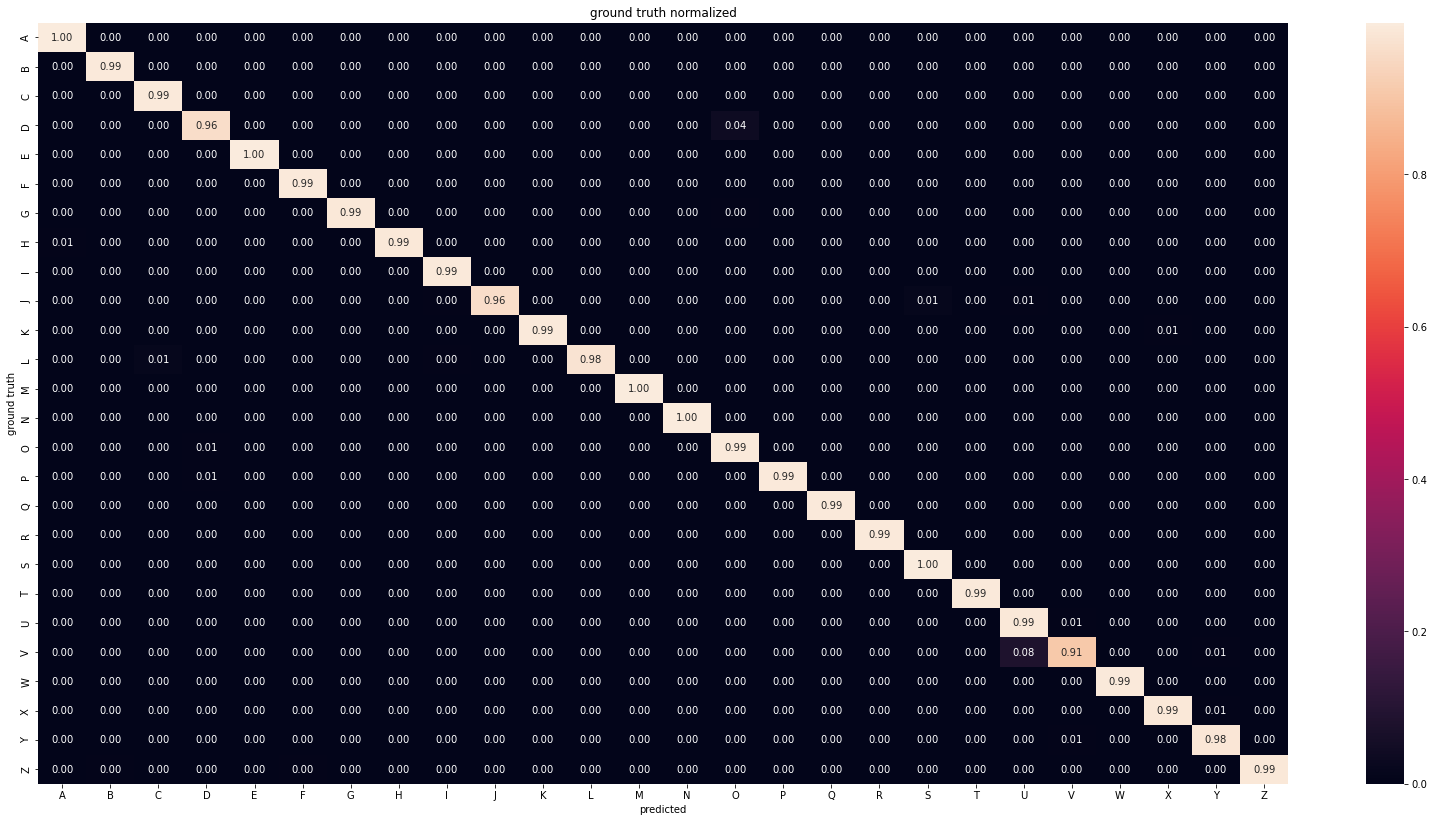

"\ni=0\nfor img, truth, pred in ic_samples:\n    plt.imshow(img)\n    plt.show()\n    print('Truth: {}, Pred: {}'.format(string.digits[int(truth)],string.digits[int(pred)]))\n"

In [18]:
import glob
models = glob.glob('./training_results/best_model_pres_resnet_unweighted_*.pt')

num_folds=5
emnist_loader = GetEmnistLoader(characters=string.ascii_uppercase, train_val_size = -1, num_folds=num_folds, transform = transform)

testloader, classes, num_classes = emnist_loader.independant_data()
model = ResNet(num_classes).to(device)

for modelpath in models:
    try:
        print(modelpath)
        model.load_state_dict(torch.load(modelpath))
        acc, ic_samples = eval_model(model, testloader)
        print("{:.3f}%".format(acc*100))
        create_confusion_matrix(model, testloader)
        plt.savefig("confusion_matrix_no_class_weights.svg")
        plt.show()
        
    except:
        print("exception!")
    
"""
i=0
for img, truth, pred in ic_samples:
    plt.imshow(img)
    plt.show()
    print('Truth: {}, Pred: {}'.format(string.digits[int(truth)],string.digits[int(pred)]))
"""

In [70]:
num_folds=5 
emnist_loader = GetEmnistLoader(train_val_size = -1, num_folds=num_folds, transform = transforms.ToTensor())
data = emnist_loader.train_val_data
loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, num_workers=worker_num, shuffle=False)

def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


mean, std = get_mean_std(loader)
print(mean)
print(std)


tensor([0.1793])
tensor([0.3354])


Z


M


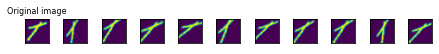

T


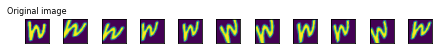

W


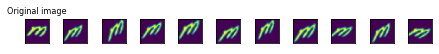

M


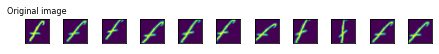

F


Q


F


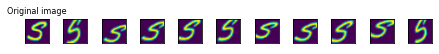

S


M


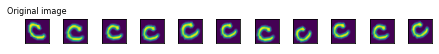

C


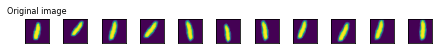

I


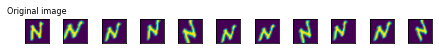

N


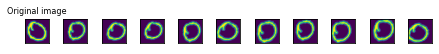

O


V


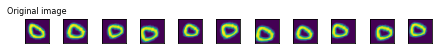

O


F


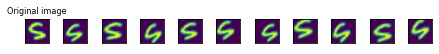

S


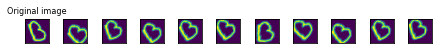

B


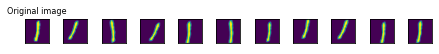

I


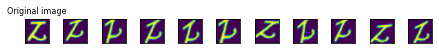

Z


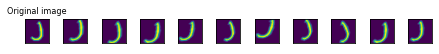

J


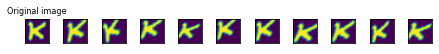

K


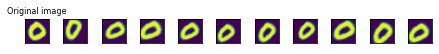

O


S


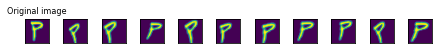

P


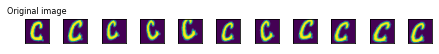

C


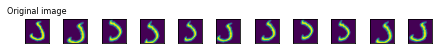

J


M


O


V


C


M


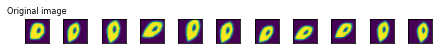

O


I


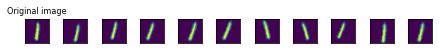

I


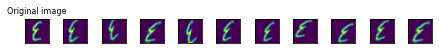

E


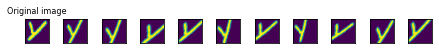

Y


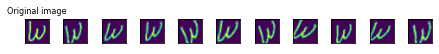

W


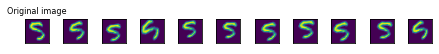

S


In [106]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)

def makeUpright(x):
    return x.permute(0,2,1).squeeze()

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

transform = transforms.Compose(
    [transforms.ToPILImage(),
     #transforms.Normalize((mean,), (std,)),
     #transforms.RandomPerspective(distortion_scale=0.9),
     T.RandomAffine(25, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(20,20), interpolation=T.InterpolationMode.BILINEAR),
     transforms.ToTensor(),
     transforms.Lambda(makeUpright),
    ])
for i in range(40):
    img, label = loader.dataset[i]
    orig_img = transforms.Lambda(makeUpright)(img)
    aug_imgs = [transform(img) for _ in range(10)]
    plot(aug_imgs)
    plt.show()
    print(string.ascii_uppercase[label])